Installing the required libraries

In [ ]:
pip install autogluon==1.1.1 numpy==1.24.4  scikit-learn==1.3.2 matplotlib==3.7.1 pandas==2.1.4

  Using cached torch-2.3.1-cp310-cp310-manylinux1_x86_64.whl.metadata (26 kB)
  Using cached torchvision-0.18.1-cp310-cp310-manylinux1_x86_64.whl.metadata (6.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
Using cached torch-2.3.1-cp310-cp310-manylinux1_x86_64.whl (779.1 MB)
Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
Using cached torchvision-0.18.1-cp310-cp310-manylinux1_x86_64.whl (7.0 MB)
  Attempting uninstall: nvidia-nccl-cu12
    Found existing installation: nvidia-nccl-cu12 2.21.5
    Uninstalling nvidia-nccl-cu12-2.21.5:
      Successfully uninstalled nvidia-nccl-cu12-2.21.5
  Attempting uninstall: nvidia-cudnn-cu12
    Found existing installation: nvidia-cudnn-cu12 9.1.0.70
    Uninstalling nvidia-cudnn-cu12-9.1.0.70:
   

In [ ]:
pip install -U torch torchaudio --no-cache-dir

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.2/797.2 MB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 116.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.4/209.4 MB 95.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 145.0 MB/s eta 0:00:00
  Attempting uninstall: triton
    Found existing installation: triton 2.3.1
    Uninstalling triton-2.3.1:
      Successfully uninstalled triton-2.3.1
  Attempting uninstall: nvidia-cudnn-cu12
    Found existing installation: nvidia-cudnn-cu12 8.9.2.26
    Uninstalling nvidia-cudnn-cu12-8.9.2.26:
      Successfully uninstalled nvidia-cudnn-cu12-8.9.2.26
  Attempting uninstall: torch
    Found existing installation: torch 2.3.1
    Uninstalling torch-2.3.1:
      Successfully uninstalled torch-2.3.1
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 2.4.0.dev20240827+cu121
    Uninstalling torchaudio-2.4.0.dev20240827+cu121:
      Successfull

Importing libraries and load AirPassenger Data set.

In [ ]:
import autogluon
#from neuralforecast.utils import AirPassengersDF
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame
from autogluon.timeseries.models import WaveNetModel
import pandas as pd

# To load local csv  > modify to the right path where the file is present
Y_df = pd.read_csv('AirPassengersDataset.csv')
Y_df = Y_df.reset_index(drop=True)

#Y_df = AirPassengersDF
#Y_df = Y_df.reset_index(drop=True)
#Y_df.head()

Define calculate error metrics function which helps in assessing the performance of the trained model

In [ ]:

def calculate_error_metrics(actual, predicted, num_predictors=1):
    # convert inputs are numpy arrays
    actual = np.array(actual)
    predicted = np.array(predicted)
    # Number of observations
    n = len(actual)
    # Calculate MSE
    mse = mean_squared_error(actual, predicted)
    # Calculate RMSE
    rmse = np.sqrt(mse)
    # Calculate MAPE
    mape = mean_absolute_percentage_error(actual, predicted)
    # Calculate R-squared
    r2 = r2_score(actual, predicted)
    # Calculate Adjusted R-squared
    adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - num_predictors - 1))
    print(f'MSE : {mse}')
    print(f'RMSE : {rmse}')
    print(f'MAPE : {mape}')
    print(f'r2 : {r2}')
    print(f'adjusted_r2 : {adjusted_r2}')

Converting date field to datetime format and renaming columns to required format

In [ ]:

Y_df['ds'] = pd.to_datetime(Y_df['ds'])
Y_df.rename(columns={"ds":"timestamp","unique_id" :"item_id", "y": "target"},inplace = True)
Y_df['item_id'] = 'airline_1'
Y_df.head()

,item_id,timestamp,target
0,airline_1,1949-01-31,112
1,airline_1,1949-02-28,118
2,airline_1,1949-03-31,132
3,airline_1,1949-04-30,129
4,airline_1,1949-05-31,121


AutoGluon expects time series data in long format. Each row of the data frame contains a single observation (timestep) of a single time series represented by

unique ID of the time series ("**item_id**") as int or str

timestamp of the observation ("**timestamp**") as a pandas.Timestamp or compatible format

numeric value of the time series ("**target**")

In [ ]:
data = TimeSeriesDataFrame.from_data_frame(
    Y_df,
    id_column="item_id",
    timestamp_column="timestamp"
)
data.tail()

target
item_id   timestamp         
airline_1 1960-08-31     606
          1960-09-30     508
          1960-10-31     461
          1960-11-30     390
          1960-12-31     432

Split data into **train** and **test**

In [ ]:
train_data = data.head(132)
test_data = data.tail(12)

Create a **TimeSeriesPredictor** object to forecast future values and explicitly define "**chronos_tiny**" to be used

In [ ]:
prediction_length =12
predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
train_data, presets="chronos_tiny"
)

Beginning AutoGluon training...
AutoGluon will save models to 'AutogluonModels/ag-20240827_222841'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.67 GB / 12.67 GB (84.2%)
Disk Space Avail:   63.52 GB / 107.72 GB (59.0%)
Setting presets to: chronos_tiny

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'tiny'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 12,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'M'
Provided train_data has 132 rows, 1 time s

Predict for the next defined horizon

In [ ]:
predictions = predictor.predict(train_data)

Model not specified in predict, will default to the model with the best validation score: Chronos[tiny]


In [ ]:
predictions

mean         0.1         0.2         0.3  \
item_id   timestamp                                                    
airline_1 1960-01-31  409.422791  384.886261  388.735138  391.429330   
          1960-02-29  418.852448  398.357269  401.436371  406.247467   
          1960-03-31  434.440369  409.518991  415.292297  418.948700   
          1960-04-30  439.636383  396.240417  405.670105  419.141153   
          1960-05-31  468.791504  426.838867  434.151703  448.777393   
          1960-06-30  533.548645  475.142120  498.812579  507.664978   
          1960-07-31  594.745544  561.741516  572.710767  574.827637   
          1960-08-31  562.126465  505.933011  509.204535  541.150043   
          1960-09-30  479.568298  430.880161  432.612152  455.127997   
          1960-10-31  407.979431  370.453009  385.271155  386.810699   
          1960-11-30  382.576965  361.600647  368.336157  370.837900   
          1960-12-31  411.251038  389.312448  394.508423  397.779947   

                             0.4         0.5         0.6         0.7  \
item_id   timestamp                                                    
airline_1 1960-01-31  396.047955  412.790543  415.677185  422.412680   
          1960-02-29  413.367871  419.526031  422.990009  426.453979   
          1960-03-31  424.914441  430.110397  436.845886  448.969839   
          1960-04-30  432.612164  441.657013  451.856476  454.165802   
          1960-05-31  454.165802  458.014664  482.647388  487.458466   
          1960-06-30  511.898743  522.483093  531.143042  550.387329   
          1960-07-31  585.412012  594.649261  602.346985  610.622052   
          1960-08-31  548.078003  557.122864  579.253821  589.068402   
          1960-09-30  477.643872  482.070053  493.424194  497.657928   
          1960-10-31  399.511932  404.130569  415.677173  425.684195   
          1960-11-30  377.188568  381.037415  384.886261  386.810699   
          1960-12-31  401.436371  408.941650  422.990009  426.453979   

                             0.8         0.9  
item_id   timestamp                           
airline_1 1960-01-31  431.457489  441.272122  
          1960-02-29  431.842377  443.004117  
          1960-03-31  454.165796  464.750153  
          1960-04-30  458.784424  464.365262  
          1960-05-31  495.348627  502.468994  
          1960-06-30  577.329407  586.374200  
          1960-07-31  618.127319  634.100153  
          1960-08-31  601.577209  615.240662  
          1960-09-30  508.819653  528.448846  
          1960-10-31  435.691248  445.505856  
          1960-11-30  401.436365  411.250998  
          1960-12-31  433.381927  447.430295

Measure the models accuracy

In [ ]:
calculate_error_metrics(test_data['target'],predictions['mean']['airline_1'])

MSE : 692.7698855972849
RMSE : 26.320522137626465
MAPE : 0.04469724962539968
r2 : 0.874939370068838
adjusted_r2 : 0.8624333070757219


Visualize the predictions

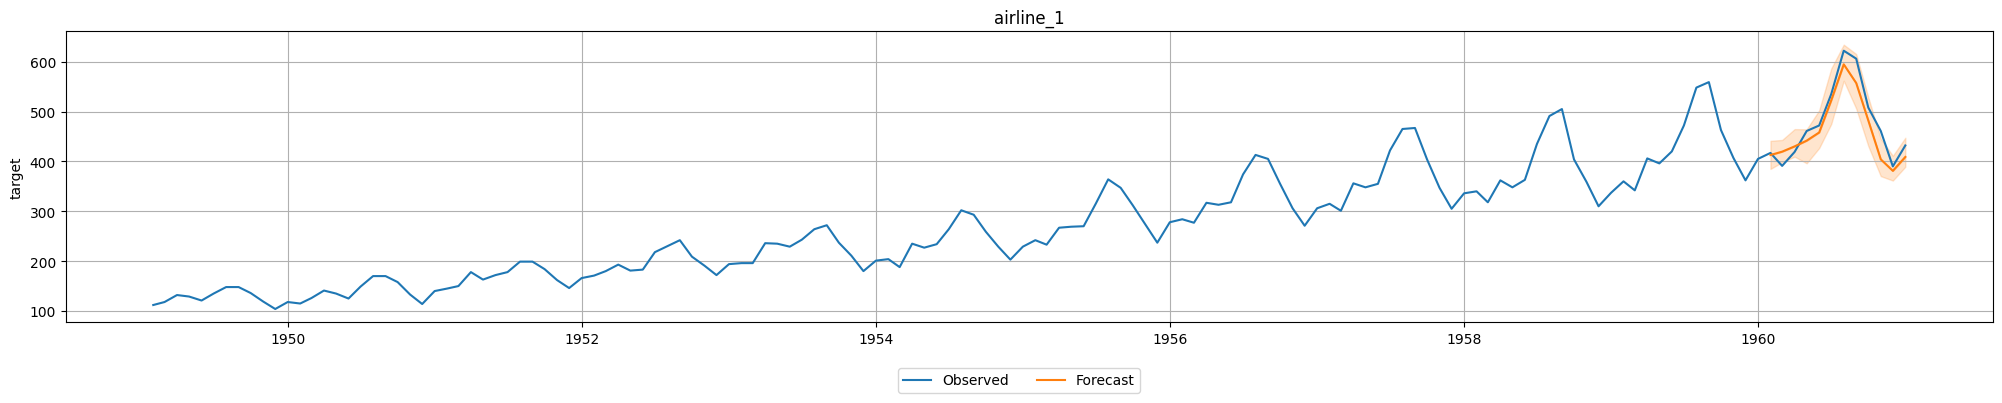

In [ ]:
predictor.plot(
    data=Y_df,
    predictions=predictions,
    item_ids=["airline_1"],
    max_history_length=200,
);